<a href="https://colab.research.google.com/github/ali-workshop/signal-recogntion/blob/main/Signal_Detection_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
import h5py
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal as sg
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.signal import correlate
from scipy.signal import find_peaks
from sklearn import svm

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pinxau1000/radioml2018


100% 18.0G/18.0G [13:01<00:00, 27.8MB/s]
100% 18.0G/18.0G [13:01<00:00, 24.7MB/s]


In [ ]:
!unzip /content/radioml2018.zip -d /content/dataset

Archive:  /content/radioml2018.zip
  inflating: /content/dataset/GOLD_XYZ_OSC.0001_1024.hdf5  
  inflating: /content/dataset/LICENSE.TXT  
  inflating: /content/dataset/classes-fixed.json  
  inflating: /content/dataset/classes-fixed.txt  
  inflating: /content/dataset/classes.txt  
  inflating: /content/dataset/datasets.desktop  


In [ ]:
# Read dataset.
hdf5_file = h5py.File("/content/dataset/GOLD_XYZ_OSC.0001_1024.hdf5", 'r')

In [ ]:
# Extract signals, modules and SNR from dataset.
data = hdf5_file['X']
modulation_onehot = hdf5_file['Y']
snr = hdf5_file['Z']

In [ ]:
# Shape of signls.
data

<HDF5 dataset "X": shape (2555904, 1024, 2), type "<f4">

In [ ]:
modulation_classes = json.load(open("/content/dataset/classes-fixed.json", 'r'))

In [ ]:
# Sets the frame number
idx = 0
# Converts the onehot encoded modulation to a readable string
modulation_str = modulation_classes[int(np.argwhere(modulation_onehot[idx] == 1))]

In [ ]:
# Prints info about the frame
print(f"Retrieving Sample {idx}\n"
      f"\t- Modulation (raw): {modulation_onehot[idx]}\n"
      f"\t- Modulation: {modulation_str}\n"
      f"\t- SNR: {snr[idx]}\n"
      f"\t- Samples: {data[idx]}")

Retrieving Sample 0
	- Modulation (raw): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	- Modulation: OOK
	- SNR: [-20]
	- Samples: [[ 0.0420274   0.23476323]
 [-0.2728826   0.40513492]
 [-0.26707262  0.22749889]
 ...
 [-0.7055947  -0.28693035]
 [-0.41157472  0.66826206]
 [ 0.06487698  0.6358149 ]]


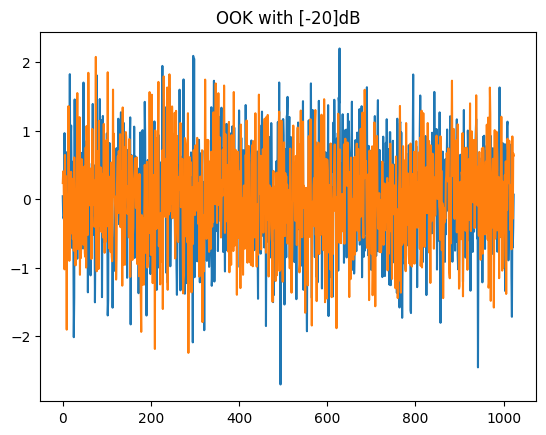

In [ ]:
# Plot I/Q samples of the frame
plt.figure()
plt.title(f"{modulation_str} with {snr[idx]}dB")
plt.plot(data[idx])
plt.show()



In [ ]:
# Extract the I/Q complex-valued waveforms from signal.
I = np.array([i[0] for i in data[idx]])
Q = np.array([i[1] for i in data[idx]])

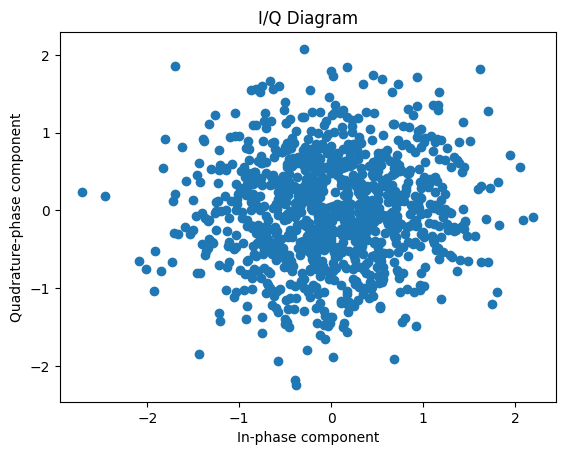

In [ ]:
plt.figure()
plt.scatter(I, Q)
plt.xlabel('In-phase component')
plt.ylabel('Quadrature-phase component')
plt.title('I/Q Diagram')
plt.show()

In [ ]:
All_Signls = data.shape[0] # Total number of signls in dataset.   (2555904)
number_of_moduls = 24      # Number of modules.
number_of_SNR_in_each_module = 26  # Number of SNR.
total_frames_in_each_modul = int(All_Signls / number_of_moduls)   # Number of signls in each modul. (2555904 // 24)
total_frames_in_each_SNR = int(total_frames_in_each_modul / number_of_SNR_in_each_module)  # Number of signls in each SNR.  (2555904 // 24) // 26

In [ ]:
# index position for each snr in one modulation.
index = []
co = 0
for i in range(-20, 31, 2):
  print("index of SNR = ", co, "," ,"SNR value = ", i)
  index.append(co)
  co+=1

index of SNR =  0 , SNR value =  -20
index of SNR =  1 , SNR value =  -18
index of SNR =  2 , SNR value =  -16
index of SNR =  3 , SNR value =  -14
index of SNR =  4 , SNR value =  -12
index of SNR =  5 , SNR value =  -10
index of SNR =  6 , SNR value =  -8
index of SNR =  7 , SNR value =  -6
index of SNR =  8 , SNR value =  -4
index of SNR =  9 , SNR value =  -2
index of SNR =  10 , SNR value =  0
index of SNR =  11 , SNR value =  2
index of SNR =  12 , SNR value =  4
index of SNR =  13 , SNR value =  6
index of SNR =  14 , SNR value =  8
index of SNR =  15 , SNR value =  10
index of SNR =  16 , SNR value =  12
index of SNR =  17 , SNR value =  14
index of SNR =  18 , SNR value =  16
index of SNR =  19 , SNR value =  18
index of SNR =  20 , SNR value =  20
index of SNR =  21 , SNR value =  22
index of SNR =  22 , SNR value =  24
index of SNR =  23 , SNR value =  26
index of SNR =  24 , SNR value =  28
index of SNR =  25 , SNR value =  30


## 16 SNR

In [ ]:
classes = ['OOK', '4ASK', 'BPSK', 'QPSK', 'AM-SSB-WC', 'AM-DSB-WC', 'FM', 'GMSK']
index_of_SNR16 = 18
dataset = []
Y = []
ind = 0
for i in range(0, All_Signls, total_frames_in_each_modul):
  if(modulation_classes[int(np.argwhere(modulation_onehot[i] == 1))] in classes):

    Start_point_of_signal_16SNR = (total_frames_in_each_modul * ind) + (total_frames_in_each_SNR * index_of_SNR16)
    End_point_of_signal_16SNR = ((total_frames_in_each_modul * ind) + (total_frames_in_each_SNR * index_of_SNR16) + total_frames_in_each_SNR)

    for j in range(Start_point_of_signal_16SNR, End_point_of_signal_16SNR):
      dataset.append(data[j])
      Y.append(modulation_onehot[j])

  ind+=1

In [ ]:
dataset = np.array(dataset)
Y = np.array(Y)

In [ ]:
print(dataset.shape)
print(Y.shape)

(32768, 1024, 2)
(32768, 24)


In [ ]:
# Merge the I/Q values of each signal to have a complex number.
dataset_Complex = []
for sam in dataset:
  dataset_Complex.append(sam[:, 0] + 1j * sam[:, 1])
dataset_Complex = np.array(dataset_Complex)

In [ ]:
# Convert the label to numirec.
label = []
for lab in Y:
  label.append(classes.index(modulation_classes[int(np.argwhere(lab == 1))]))
label = np.array(label)

In [ ]:
print(dataset_Complex.shape)
print(label.shape)

(32768, 1024)
(32768,)


In [ ]:
def Extract_features(com_sig):
  I = np.real(com_sig)
  Q = np.imag(com_sig)

  # Compute the skewness of the signal amplitude
  mag = np.abs(com_sig)
  amp_skew = skew(mag)

  # Compute the kurtosis of the signal amplitude
  amp_kurt = kurtosis(mag)

  # Compute the root mean square (RMS) and crest factor of the I and Q components
  I_rms = np.sqrt(np.mean(I**2))
  Q_rms = np.sqrt(np.mean(Q**2))
  I_crest_factor = np.max(np.abs(I)) / I_rms
  Q_crest_factor = np.max(np.abs(Q)) / Q_rms

  return [I_crest_factor, Q_crest_factor, I_rms, Q_rms, amp_skew, amp_kurt]

In [ ]:
# Pass the samples to the function to extract features.
features = np.array([Extract_features(sig) for sig in dataset_Complex])

In [ ]:
print(features.shape)
print(label.shape)

(32768, 6)
(32768,)


In [ ]:
# Scale the features.
scaler = StandardScaler()
features_standard = scaler.fit_transform(features)

In [ ]:
# Splite the dataset to train and test.
X_train, X_test, y_train, y_test = train_test_split(features_standard, label, test_size = 0.2, random_state = 42, shuffle = True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26214, 6)
(26214,)
(6554, 6)
(6554,)


In [ ]:
# Define SVM .
clf = svm.SVC(kernel= 'rbf')

In [ ]:
# Training....
clf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import classification_report
# Get the prediction.
y_pred = clf.predict(X_test)

# Calculate and print the performance metrics of the SVM model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       1.00      1.00      1.00       821
           2       1.00      1.00      1.00       825
           3       1.00      1.00      1.00       868
           4       1.00      1.00      1.00       821
           5       1.00      1.00      1.00       778
           6       1.00      1.00      1.00       833
           7       1.00      1.00      1.00       823

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00      1.00      6554



In [ ]:
sig = dataset_Complex[0]
lab = label[0]

In [ ]:
print("This signal is belongs to ", classes[lab], " module.")

This signal is belongs to  OOK  module.


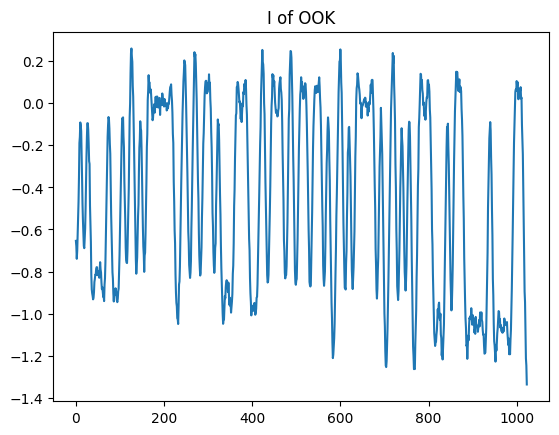

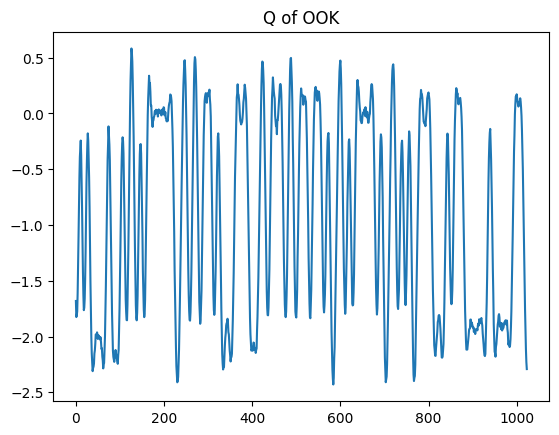

In [ ]:
I = np.real(sig)
Q = np.imag(sig)
# Plot I/Q samples of the frame
plt.figure()
plt.title("I of " + classes[lab])
plt.plot(I)
plt.figure()
plt.title("Q of " + classes[lab])
plt.plot(Q)
plt.show()

In [ ]:
# Extract the features.
fea = np.array(Extract_features(sig)).reshape(1, -1)
# Scale the features.
fea_standard = scaler.transform(fea)
# Get the prediction.
pre = clf.predict(fea_standard)

In [ ]:
print("The prediction is ", classes[pre[0]])

The prediction is  OOK


In [ ]:
sig = dataset_Complex[10000]
lab = label[10000]

In [ ]:
print("This signal is belongs to ", classes[lab], " module.")

This signal is belongs to  BPSK  module.


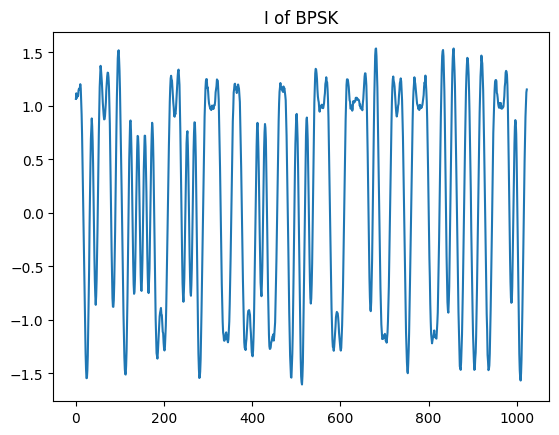

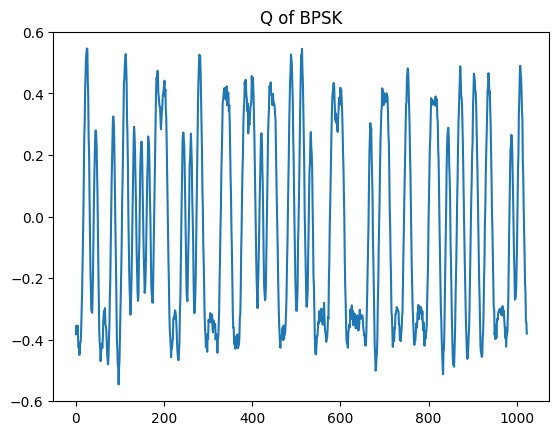

In [ ]:
I = np.real(sig)
Q = np.imag(sig)
# Plot I/Q samples of the frame
plt.figure()
plt.title("I of " + classes[lab] + " with SNR 16")
plt.plot(I)
plt.figure()
plt.title("Q of " + classes[lab] + " with SNR 16")
plt.plot(Q)
plt.show()

In [ ]:
# Extract the features.
fea = np.array(Extract_features(sig)).reshape(1, -1)
# Scale the features.
fea_standard = scaler.transform(fea)
# Get the prediction.
pre = clf.predict(fea_standard)

In [ ]:
print("The prediction is ", classes[pre[0]])

The prediction is  BPSK


## 26 SNR

In [ ]:
classes = ['OOK', '4ASK', 'BPSK', 'QPSK', 'AM-SSB-WC', 'AM-DSB-WC', 'FM', 'GMSK']
index_of_SNR26 = 23
dataset = []
Y = []
ind = 0
for i in range(0, All_Signls, total_frames_in_each_modul):
  if(modulation_classes[int(np.argwhere(modulation_onehot[i] == 1))] in classes):

    Start_point_of_signal_26SNR = (total_frames_in_each_modul * ind) + (total_frames_in_each_SNR * index_of_SNR26)
    End_point_of_signal_26SNR = ((total_frames_in_each_modul * ind) + (total_frames_in_each_SNR * index_of_SNR26) + total_frames_in_each_SNR)

    for j in range(Start_point_of_signal_26SNR, End_point_of_signal_26SNR):
      dataset.append(data[j])
      Y.append(modulation_onehot[j])

  ind+=1

In [ ]:
dataset = np.array(dataset)
Y = np.array(Y)

In [ ]:
print(dataset.shape)
print(Y.shape)

(32768, 1024, 2)
(32768, 24)


In [ ]:
# Merge the I/Q values of each signal to have a complex number.
dataset_Complex = []
for sam in dataset:
  dataset_Complex.append(sam[:, 0] + 1j * sam[:, 1])
dataset_Complex = np.array(dataset_Complex)

In [ ]:
# Convert the label to numirec.
label = []
for lab in Y:
  label.append(classes.index(modulation_classes[int(np.argwhere(lab == 1))]))
label = np.array(label)

In [ ]:
print(dataset_Complex.shape)
print(label.shape)

(32768, 1024)
(32768,)


In [ ]:
def Extract_features(com_sig):
  I = np.real(com_sig)
  Q = np.imag(com_sig)

  # Compute the skewness of the signal amplitude
  mag = np.abs(com_sig)
  amp_skew = skew(mag)

  # Compute the kurtosis of the signal amplitude
  amp_kurt = kurtosis(mag)

  # Compute the root mean square (RMS) and crest factor of the I and Q components
  I_rms = np.sqrt(np.mean(I**2))
  Q_rms = np.sqrt(np.mean(Q**2))
  I_crest_factor = np.max(np.abs(I)) / I_rms
  Q_crest_factor = np.max(np.abs(Q)) / Q_rms

  return [I_crest_factor, Q_crest_factor, I_rms, Q_rms, amp_skew, amp_kurt]

In [ ]:
# Pass the samples to the function to extract features.
features = np.array([Extract_features(sig) for sig in dataset_Complex])

In [ ]:
print(features.shape)
print(label.shape)

(32768, 6)
(32768,)


In [ ]:
# Scale the features.
scaler = StandardScaler()
features_standard = scaler.fit_transform(features)

In [ ]:
# Splite the dataset to train and test.
X_train, X_test, y_train, y_test = train_test_split(features_standard, label, test_size = 0.2, random_state = 42, shuffle = True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26214, 6)
(26214,)
(6554, 6)
(6554,)


In [ ]:
# Define SVM .
clf = svm.SVC(kernel= 'rbf')

In [ ]:
# Training....
clf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import classification_report
# Get the prediction.
y_pred = clf.predict(X_test)

# Calculate and print the performance metrics of the SVM model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       785
           1       1.00      0.95      0.97       821
           2       0.96      0.96      0.96       825
           3       0.99      0.99      0.99       868
           4       1.00      1.00      1.00       821
           5       0.97      0.97      0.97       778
           6       1.00      1.00      1.00       833
           7       1.00      1.00      1.00       823

    accuracy                           0.98      6554
   macro avg       0.98      0.98      0.98      6554
weighted avg       0.98      0.98      0.98      6554



In [ ]:
sig = dataset_Complex[0]
lab = label[0]

In [ ]:
print("This signal is belongs to ", classes[lab], " module.")

This signal is belongs to  OOK  module.


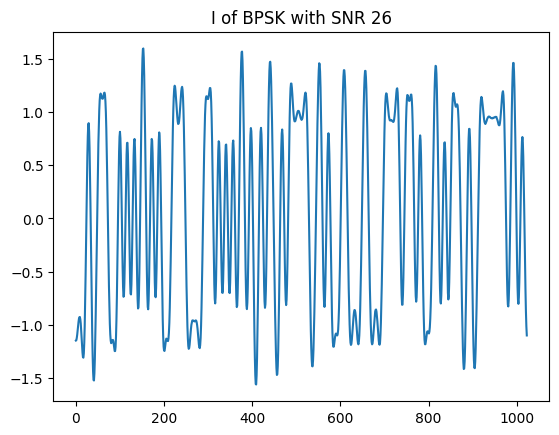

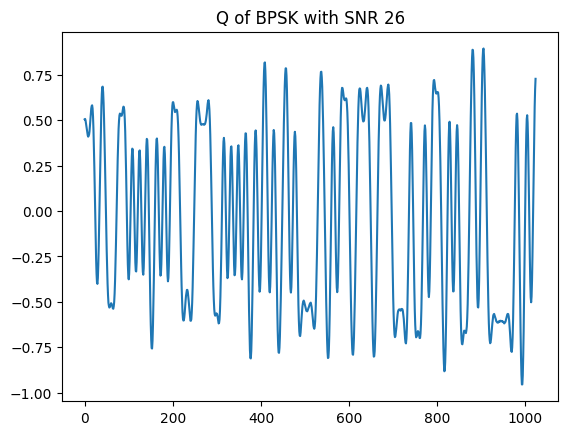

In [ ]:
I = np.real(sig)
Q = np.imag(sig)
# Plot I/Q samples of the frame
plt.figure()
plt.title("I of " + classes[lab] + " with SNR 26")
plt.plot(I)
plt.figure()
plt.title("Q of " + classes[lab] + " with SNR 26")
plt.plot(Q)
plt.show()

In [ ]:
# Extract the features.
fea = np.array(Extract_features(sig)).reshape(1, -1)
# Scale the features.
fea_standard = scaler.transform(fea)
# Get the prediction.
pre = clf.predict(fea_standard)

In [ ]:
print("The prediction is ", classes[pre[0]])

The prediction is  OOK


In [ ]:
sig = dataset_Complex[10000]
lab = label[10000]

In [ ]:
print("This signal is belongs to ", classes[lab], " module.")

This signal is belongs to  BPSK  module.


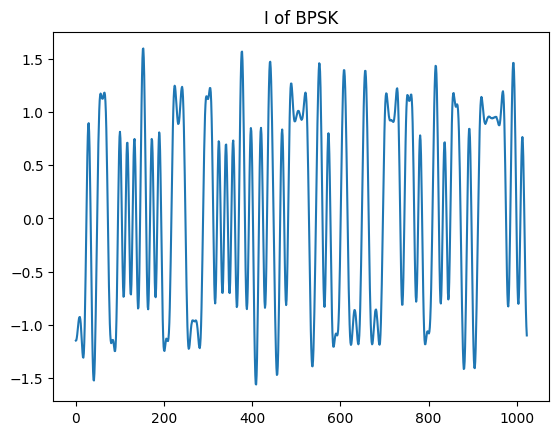

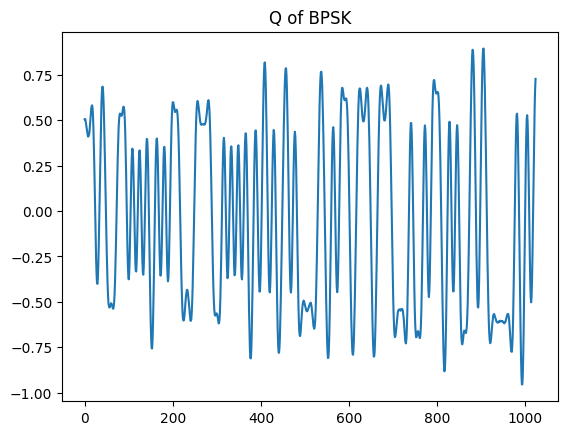

In [ ]:
I = np.real(sig)
Q = np.imag(sig)
# Plot I/Q samples of the frame
plt.figure()
plt.title("I of " + classes[lab])
plt.plot(I)
plt.figure()
plt.title("Q of " + classes[lab])
plt.plot(Q)
plt.show()

In [ ]:
# Extract the features.
fea = np.array(Extract_features(sig)).reshape(1, -1)
# Scale the features.
fea_standard = scaler.transform(fea)
# Get the prediction.
pre = clf.predict(fea_standard)

In [ ]:
print("The prediction is ", classes[pre[0]])

The prediction is  BPSK
